In [1]:
from lib_linear import *
import time
import torch.nn.functional as F
from copy import deepcopy



## read diagonalized iinput-input, input-output and output-output matrices

In [2]:
input_input_matrix = np.array(pd.read_csv('input_input_matrix.csv'))
output_input_matrix = np.array(pd.read_csv('output_input_matrix.csv'))
output_output_matrix = np.array(pd.read_csv('output_output_matrix.csv'))

V_matrix = np.array(pd.read_csv('V_matrix.csv'))
U_matrix = np.array(pd.read_csv('U_matrix.csv'))
S31_matrix = np.array(pd.read_csv('S_matrix.csv'))  ##actually, just diag values

S11_matrix = V_matrix.T @ input_input_matrix @ V_matrix
S33_matrix = output_output_matrix

S_improved  = pd.read_csv('700/S_improved.csv')
S11_improved = np.array(S_improved['S11'])
S31_improved = np.array(S_improved['S31'])

## Data

In [3]:
mean, std = calculate_mean_and_std()
train_data, test_data =  download_normalized_data(mean, std)

batch_size: int = 1000
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

## Neural network model

In [4]:
class CustomNetwork(object):
    
    """
    Simple D-layer linear neural network 
    hidden_dims = topule(n0, n1, n2, ...nD)
    n0 = input layer
    n_D = output layer
    """
    
    def __init__(self, D, layers_dim):
        
        """
        Initialize network's weights according to Gaussian iid and network's biases with 0.0 values
        """
        
        self.weights = []
        self.D = len(layers_dim)-1
        assert self.D == D
                
        for i in range(self.D):
            weight: torch.Tensor = torch.rand((layers_dim[i+1], layers_dim[i])) 
            stdv = 2/ np.sqrt(layers_dim[i])
            weight = (weight-0.5)*stdv
            weight.requires_grad = True
            self.weights.append(weight)
    
            
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network
        """
        for i in range(0,self.D):            
            x = torch.nn.functional.linear( input = x, weight=self.weights[i])
        return x 
    
    
    def parameters(self) -> List[torch.Tensor]:
        """
        Returns all trainable parameters 
        """
        return self.weights

In [5]:
input_dim = 784
output_dim = 10
hidden_dim1 = 700
D = 2
model: CustomNetwork = CustomNetwork(D = D, layers_dim = (input_dim, hidden_dim1, output_dim))

## Training parameters

In [6]:
# initialize the optimizer using the hyperparams below
lr: float = 0.005
momentum: float = 0.00
optimizer: torch.optim.Optimizer = SGD(params = model.parameters(), lr=lr)
criterion = nn.MSELoss() 
epoch: int = 3000

In [7]:
term_I_tab=[]
term_II_tab = []
term_IV_tab = []

term_I_star_tab=[]
term_II_star_tab = []
term_IV_star_tab = []

term_I_diamond_tab=[]
term_II_diamond_tab = []
term_IV_diamond_tab = []

## Training loop

In [8]:
for e in range(epoch):
    for inner_counter, (x, y) in enumerate(train_loader):

        optimizer.zero_grad()
        output: torch.Tensor = model(x)  
        y=F.one_hot(y, num_classes=10).float()
        loss: torch.Tensor = criterion(output, y)
        loss.backward()
        optimizer.step()     
    
    #add model parameters to tab
    loss_tab.append(loss.item())
    params_tab = []
    for param in model.parameters():
        params_tab.append(param.detach().numpy().flatten()  )
    w1_mean_tab.append(params_tab[0].mean())
    w2_mean_tab.append(params_tab[1].mean())
    w1_std_tab.append(params_tab[0].std())
    w2_std_tab.append(params_tab[1].std())

    # at the end of an epoch run evaluation on the test set
    with torch.no_grad():
        correct: int = 0 
        for i, (x, y) in enumerate(train_loader):
            output: torch.Tensor = model(x)
            pred_labels = torch.argmax(output, 1)
            correct += ( (pred_labels -y) ==0).sum()
        train_accuracy_tab.append( float(correct) / len(train_data))
        correct: int = 0 
        for i, (x, y) in enumerate(test_loader):
            output: torch.Tensor = model(x)
            pred_labels = torch.argmax(output, 1)
            correct += ( (pred_labels -y) ==0).sum()
        test_accuracy_tab.append( float(correct) / len(test_data))
    
    # save params
    params=[]
    for param in model.parameters():
        params.append(param.detach().numpy())
    w1=params[0] 
    w2=params[1]

    R = U_matrix.T @ w2 @ w1 @ V_matrix

    ######################### original terms ########################    
    term_1 = 0
    for alpha in range(10):
        term_1 += (R[alpha][alpha] - S31_matrix[alpha]/S11_matrix[alpha][alpha])**2 * S11_matrix[alpha][alpha]
    term_2 = 0
    for beta in range(10):
        for alpha in range(784):
            if(alpha != beta):
                term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]
    term_4 = 0
    for alpha in range(10):
        term_4+= (S31_matrix[alpha])**2/S11_matrix[alpha][alpha]

    term_I_tab.append(round(float(term_1), 6))
    term_II_tab.append(round(float(term_2), 6))
    term_IV_tab.append(round(float(term_4), 6))
    
    
    ########################## S11 diamond ##########################
    term_1 = 0
    for alpha in range(10):
        term_1 += (R[alpha][alpha] - S31_matrix[alpha]/S11_improved[alpha])**2 * S11_improved[alpha]
    term_2 = 0
    for beta in range(10):
        for alpha in range(784):
            if(alpha != beta):
                if alpha <10:
                    term_2 += (R[beta][alpha])**2 * S11_improved[alpha]
                else:
                    term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]

    term_4 = 0
    for alpha in range(10):
        term_4+= (S31_matrix[alpha])**2/S11_improved[alpha]
  
    term_I_diamond_tab.append(round(float(term_1), 6))
    term_II_diamond_tab.append(round(float(term_2), 6))
    term_IV_diamond_tab.append(round(float(term_4), 6))
    
    
    ########################## S31 star ##########################    
    term_1 = 0
    for alpha in range(10):
        term_1 += (R[alpha][alpha] - S31_improved[alpha]/S11_matrix[alpha][alpha])**2 * S11_matrix[alpha][alpha]
    term_2 = 0
    for beta in range(10):
        for alpha in range(784):
            if(alpha != beta):
                term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]
    term_4 = 0
    for alpha in range(10):
        term_4+= (S31_improved[alpha])**2/S11_matrix[alpha][alpha]
       
    term_I_star_tab.append(round(float(term_1), 6))
    term_II_star_tab.append(round(float(term_2), 6))
    term_IV_star_tab.append(round(float(term_4), 6))
    
    print(f'{e} loss = {loss} test acc {test_accuracy_tab[-1]}')

0 loss = 0.09445405751466751 test acc 0.4616
1 loss = 0.07449591159820557 test acc 0.6145
2 loss = 0.0651087537407875 test acc 0.6841
3 loss = 0.05954655632376671 test acc 0.7239
4 loss = 0.055853791534900665 test acc 0.7517
5 loss = 0.05321882292628288 test acc 0.7679
6 loss = 0.05124102905392647 test acc 0.7809
7 loss = 0.04969974607229233 test acc 0.7903
8 loss = 0.048463355749845505 test acc 0.7979
9 loss = 0.0474482998251915 test acc 0.8033
10 loss = 0.046598926186561584 test acc 0.8085
11 loss = 0.04587670415639877 test acc 0.8138
12 loss = 0.04525410011410713 test acc 0.8181
13 loss = 0.04471096396446228 test acc 0.8212
14 loss = 0.044232189655303955 test acc 0.8242
15 loss = 0.04380626976490021 test acc 0.8263
16 loss = 0.04342431202530861 test acc 0.828
17 loss = 0.04307928308844566 test acc 0.8306
18 loss = 0.04276563227176666 test acc 0.8327
19 loss = 0.04247886687517166 test acc 0.835
20 loss = 0.04221532866358757 test acc 0.8366
21 loss = 0.041972022503614426 test acc 0.83

176 loss = 0.03559233993291855 test acc 0.8607
177 loss = 0.03558271378278732 test acc 0.8606
178 loss = 0.03557317331433296 test acc 0.8606
179 loss = 0.035563722252845764 test acc 0.8605
180 loss = 0.035554345697164536 test acc 0.8606
181 loss = 0.03554505482316017 test acc 0.8607
182 loss = 0.03553583845496178 test acc 0.8607
183 loss = 0.03552670404314995 test acc 0.8607
184 loss = 0.03551764413714409 test acc 0.8607
185 loss = 0.03550867363810539 test acc 0.8609
186 loss = 0.03549976646900177 test acc 0.8609
187 loss = 0.035490941256284714 test acc 0.861
188 loss = 0.03548219054937363 test acc 0.8611
189 loss = 0.03547350689768791 test acc 0.8612
190 loss = 0.035464901477098465 test acc 0.861
191 loss = 0.03545636683702469 test acc 0.8611
192 loss = 0.035447895526885986 test acc 0.8609
193 loss = 0.03543950244784355 test acc 0.8611
194 loss = 0.03543117269873619 test acc 0.8611
195 loss = 0.0354229174554348 test acc 0.8613
196 loss = 0.03541472181677818 test acc 0.861
197 loss = 0

350 loss = 0.034638628363609314 test acc 0.8607
351 loss = 0.034635525196790695 test acc 0.8608
352 loss = 0.03463243320584297 test acc 0.8607
353 loss = 0.03462936356663704 test acc 0.8605
354 loss = 0.034626301378011703 test acc 0.8604
355 loss = 0.03462326154112816 test acc 0.8602
356 loss = 0.03462022915482521 test acc 0.8602
357 loss = 0.03461722284555435 test acc 0.8602
358 loss = 0.03461422026157379 test acc 0.8602
359 loss = 0.034611236304044724 test acc 0.8601
360 loss = 0.03460826352238655 test acc 0.8601
361 loss = 0.03460530936717987 test acc 0.8601
362 loss = 0.034602370113134384 test acc 0.8601
363 loss = 0.03459944576025009 test acc 0.8601
364 loss = 0.03459653630852699 test acc 0.8601
365 loss = 0.03459363803267479 test acc 0.8602
366 loss = 0.03459075465798378 test acc 0.86
367 loss = 0.034587886184453964 test acc 0.8599
368 loss = 0.034585025161504745 test acc 0.8598
369 loss = 0.03458218276500702 test acc 0.8598
370 loss = 0.034579355269670486 test acc 0.8598
371 los

524 loss = 0.03426308557391167 test acc 0.8592
525 loss = 0.03426160663366318 test acc 0.8592
526 loss = 0.03426012396812439 test acc 0.8592
527 loss = 0.034258656203746796 test acc 0.8592
528 loss = 0.0342571884393692 test acc 0.8592
529 loss = 0.034255724400281906 test acc 0.8591
530 loss = 0.034254271537065506 test acc 0.8591
531 loss = 0.034252822399139404 test acc 0.8591
532 loss = 0.0342513732612133 test acc 0.8591
533 loss = 0.0342499315738678 test acc 0.8591
534 loss = 0.03424849733710289 test acc 0.8591
535 loss = 0.03424706682562828 test acc 0.8591
536 loss = 0.03424564376473427 test acc 0.859
537 loss = 0.034244224429130554 test acc 0.8591
538 loss = 0.03424280881881714 test acc 0.8591
539 loss = 0.03424139693379402 test acc 0.8592
540 loss = 0.0342399962246418 test acc 0.8592
541 loss = 0.03423859551548958 test acc 0.8592
542 loss = 0.034237198531627655 test acc 0.8592
543 loss = 0.03423580527305603 test acc 0.8592
544 loss = 0.0342344231903553 test acc 0.8592
545 loss = 0.

698 loss = 0.03406814858317375 test acc 0.8599
699 loss = 0.034067314118146896 test acc 0.8597
700 loss = 0.03406647965312004 test acc 0.8597
701 loss = 0.03406564146280289 test acc 0.8598
702 loss = 0.03406481444835663 test acc 0.8598
703 loss = 0.03406398743391037 test acc 0.8598
704 loss = 0.03406316041946411 test acc 0.8599
705 loss = 0.03406233713030815 test acc 0.8599
706 loss = 0.03406151756644249 test acc 0.8599
707 loss = 0.03406069800257683 test acc 0.8599
708 loss = 0.034059878438711166 test acc 0.8598
709 loss = 0.0340590700507164 test acc 0.8598
710 loss = 0.03405825048685074 test acc 0.8598
711 loss = 0.03405744954943657 test acc 0.8598
712 loss = 0.0340566448867321 test acc 0.8598
713 loss = 0.034055836498737335 test acc 0.8598
714 loss = 0.034055035561323166 test acc 0.8598
715 loss = 0.034054238349199295 test acc 0.8598
716 loss = 0.034053441137075424 test acc 0.8599
717 loss = 0.03405264765024185 test acc 0.8599
718 loss = 0.03405185416340828 test acc 0.8599
719 loss 

872 loss = 0.033952560275793076 test acc 0.8598
873 loss = 0.03395203873515129 test acc 0.8598
874 loss = 0.03395151346921921 test acc 0.8598
875 loss = 0.03395099565386772 test acc 0.8598
876 loss = 0.033950477838516235 test acc 0.8598
877 loss = 0.03394995629787445 test acc 0.8598
878 loss = 0.03394944593310356 test acc 0.8598
879 loss = 0.03394892439246178 test acc 0.8598
880 loss = 0.03394841402769089 test acc 0.8598
881 loss = 0.03394790366292 test acc 0.8598
882 loss = 0.03394738957285881 test acc 0.8598
883 loss = 0.03394688293337822 test acc 0.8598
884 loss = 0.03394637256860733 test acc 0.8598
885 loss = 0.03394586592912674 test acc 0.8598
886 loss = 0.03394535556435585 test acc 0.8598
887 loss = 0.033944856375455856 test acc 0.8598
888 loss = 0.033944349735975266 test acc 0.8598
889 loss = 0.033943843096494675 test acc 0.8598
890 loss = 0.03394334763288498 test acc 0.8598
891 loss = 0.033942848443984985 test acc 0.8598
892 loss = 0.03394234925508499 test acc 0.8598
893 loss =

1046 loss = 0.03387799486517906 test acc 0.86
1047 loss = 0.033877644687891006 test acc 0.86
1048 loss = 0.03387729823589325 test acc 0.86
1049 loss = 0.03387695178389549 test acc 0.86
1050 loss = 0.033876605331897736 test acc 0.86
1051 loss = 0.03387625887989998 test acc 0.86
1052 loss = 0.03387591242790222 test acc 0.86
1053 loss = 0.03387556970119476 test acc 0.86
1054 loss = 0.033875223249197006 test acc 0.8599
1055 loss = 0.03387488052248955 test acc 0.8599
1056 loss = 0.03387453779578209 test acc 0.8599
1057 loss = 0.03387419879436493 test acc 0.8599
1058 loss = 0.03387385234236717 test acc 0.8599
1059 loss = 0.03387351706624031 test acc 0.8599
1060 loss = 0.03387317433953285 test acc 0.8599
1061 loss = 0.03387283533811569 test acc 0.8599
1062 loss = 0.03387249633669853 test acc 0.8599
1063 loss = 0.03387216106057167 test acc 0.8599
1064 loss = 0.03387182205915451 test acc 0.8599
1065 loss = 0.03387148678302765 test acc 0.8599
1066 loss = 0.033871155232191086 test acc 0.8599
1067

1217 loss = 0.03382767736911774 test acc 0.8602
1218 loss = 0.03382742777466774 test acc 0.8602
1219 loss = 0.03382717818021774 test acc 0.8602
1220 loss = 0.03382693603634834 test acc 0.8602
1221 loss = 0.033826686441898346 test acc 0.8603
1222 loss = 0.033826448023319244 test acc 0.8603
1223 loss = 0.033826202154159546 test acc 0.8603
1224 loss = 0.033825960010290146 test acc 0.8603
1225 loss = 0.033825717866420746 test acc 0.8602
1226 loss = 0.03382546827197075 test acc 0.8602
1227 loss = 0.033825233578681946 test acc 0.8602
1228 loss = 0.03382498770952225 test acc 0.8602
1229 loss = 0.03382474556565285 test acc 0.8603
1230 loss = 0.033824507147073746 test acc 0.8603
1231 loss = 0.03382426127791405 test acc 0.8604
1232 loss = 0.033824022859334946 test acc 0.8604
1233 loss = 0.033823780715465546 test acc 0.8604
1234 loss = 0.03382354602217674 test acc 0.8604
1235 loss = 0.03382330760359764 test acc 0.8604
1236 loss = 0.03382306545972824 test acc 0.8604
1237 loss = 0.03382283076643944

1387 loss = 0.033791616559028625 test acc 0.8604
1388 loss = 0.0337914377450943 test acc 0.8604
1389 loss = 0.033791255205869675 test acc 0.8604
1390 loss = 0.03379107639193535 test acc 0.8604
1391 loss = 0.033790893852710724 test acc 0.8604
1392 loss = 0.0337907150387764 test acc 0.8604
1393 loss = 0.03379053249955177 test acc 0.8604
1394 loss = 0.03379035368561745 test acc 0.8604
1395 loss = 0.03379017487168312 test acc 0.8604
1396 loss = 0.033789996057748795 test acc 0.8604
1397 loss = 0.03378981724381447 test acc 0.8604
1398 loss = 0.03378964215517044 test acc 0.8604
1399 loss = 0.033789463341236115 test acc 0.8605
1400 loss = 0.03378928080201149 test acc 0.8605
1401 loss = 0.03378910571336746 test acc 0.8605
1402 loss = 0.033788926899433136 test acc 0.8605
1403 loss = 0.03378875553607941 test acc 0.8605
1404 loss = 0.03378857299685478 test acc 0.8605
1405 loss = 0.03378840163350105 test acc 0.8605
1406 loss = 0.033788226544857025 test acc 0.8605
1407 loss = 0.0337880477309227 test

1557 loss = 0.03376470506191254 test acc 0.8604
1558 loss = 0.033764567226171494 test acc 0.8604
1559 loss = 0.03376443311572075 test acc 0.8604
1560 loss = 0.033764295279979706 test acc 0.8604
1561 loss = 0.033764153718948364 test acc 0.8604
1562 loss = 0.03376401960849762 test acc 0.8604
1563 loss = 0.03376388177275658 test acc 0.8604
1564 loss = 0.03376374393701553 test acc 0.8604
1565 loss = 0.03376360982656479 test acc 0.8604
1566 loss = 0.033763471990823746 test acc 0.8604
1567 loss = 0.033763337880373 test acc 0.8604
1568 loss = 0.033763207495212555 test acc 0.8604
1569 loss = 0.03376306965947151 test acc 0.8604
1570 loss = 0.03376293182373047 test acc 0.8603
1571 loss = 0.033762797713279724 test acc 0.8603
1572 loss = 0.03376266360282898 test acc 0.8603
1573 loss = 0.033762525767087936 test acc 0.8603
1574 loss = 0.03376239165663719 test acc 0.8603
1575 loss = 0.03376225754618645 test acc 0.8603
1576 loss = 0.0337621234357357 test acc 0.8603
1577 loss = 0.033761993050575256 tes

1727 loss = 0.03374404460191727 test acc 0.8606
1728 loss = 0.03374393284320831 test acc 0.8606
1729 loss = 0.03374382480978966 test acc 0.8606
1730 loss = 0.0337437205016613 test acc 0.8606
1731 loss = 0.033743616193532944 test acc 0.8607
1732 loss = 0.03374350816011429 test acc 0.8607
1733 loss = 0.03374340385198593 test acc 0.8607
1734 loss = 0.033743295818567276 test acc 0.8607
1735 loss = 0.03374319151043892 test acc 0.8607
1736 loss = 0.033743083477020264 test acc 0.8606
1737 loss = 0.03374297916889191 test acc 0.8606
1738 loss = 0.03374287486076355 test acc 0.8606
1739 loss = 0.03374277055263519 test acc 0.8607
1740 loss = 0.03374266251921654 test acc 0.8607
1741 loss = 0.03374255821108818 test acc 0.8607
1742 loss = 0.033742453902959824 test acc 0.8607
1743 loss = 0.03374234959483147 test acc 0.8607
1744 loss = 0.03374224901199341 test acc 0.8607
1745 loss = 0.03374214470386505 test acc 0.8607
1746 loss = 0.033742036670446396 test acc 0.8607
1747 loss = 0.03374193236231804 test

1899 loss = 0.03372764214873314 test acc 0.861
1900 loss = 0.033727556467056274 test acc 0.861
1901 loss = 0.03372746706008911 test acc 0.861
1902 loss = 0.033727385103702545 test acc 0.861
1903 loss = 0.03372729942202568 test acc 0.8611
1904 loss = 0.033727217465639114 test acc 0.8611
1905 loss = 0.03372713178396225 test acc 0.8611
1906 loss = 0.033727049827575684 test acc 0.8611
1907 loss = 0.03372696414589882 test acc 0.8611
1908 loss = 0.03372688591480255 test acc 0.8611
1909 loss = 0.03372680023312569 test acc 0.8611
1910 loss = 0.03372671455144882 test acc 0.8611
1911 loss = 0.03372662514448166 test acc 0.8611
1912 loss = 0.03372654691338539 test acc 0.8611
1913 loss = 0.03372646123170853 test acc 0.8611
1914 loss = 0.03372637927532196 test acc 0.8611
1915 loss = 0.033726293593645096 test acc 0.8611
1916 loss = 0.03372621536254883 test acc 0.8611
1917 loss = 0.033726129680871964 test acc 0.8611
1918 loss = 0.033726051449775696 test acc 0.8611
1919 loss = 0.03372596576809883 test 

2071 loss = 0.03371452912688255 test acc 0.8607
2072 loss = 0.033714454621076584 test acc 0.8607
2073 loss = 0.03371438756585121 test acc 0.8607
2074 loss = 0.03371432051062584 test acc 0.8607
2075 loss = 0.03371425345540047 test acc 0.8607
2076 loss = 0.033714186400175095 test acc 0.8607
2077 loss = 0.03371411934494972 test acc 0.8607
2078 loss = 0.03371404856443405 test acc 0.8607
2079 loss = 0.03371397778391838 test acc 0.8607
2080 loss = 0.03371391072869301 test acc 0.8607
2081 loss = 0.033713843673467636 test acc 0.8607
2082 loss = 0.03371378034353256 test acc 0.8607
2083 loss = 0.03371370956301689 test acc 0.8607
2084 loss = 0.03371364623308182 test acc 0.8607
2085 loss = 0.03371357545256615 test acc 0.8607
2086 loss = 0.033713508397340775 test acc 0.8607
2087 loss = 0.0337134413421154 test acc 0.8607
2088 loss = 0.03371337056159973 test acc 0.8607
2089 loss = 0.03371330723166466 test acc 0.8607
2090 loss = 0.033713240176439285 test acc 0.8607
2091 loss = 0.03371317312121391 test

2241 loss = 0.03370395675301552 test acc 0.8608
2242 loss = 0.03370390087366104 test acc 0.8608
2243 loss = 0.033703841269016266 test acc 0.8608
2244 loss = 0.03370378538966179 test acc 0.8608
2245 loss = 0.03370372951030731 test acc 0.8608
2246 loss = 0.03370366990566254 test acc 0.8608
2247 loss = 0.03370361775159836 test acc 0.8608
2248 loss = 0.03370356559753418 test acc 0.8608
2249 loss = 0.033703502267599106 test acc 0.8608
2250 loss = 0.03370345011353493 test acc 0.8608
2251 loss = 0.03370339423418045 test acc 0.8608
2252 loss = 0.033703338354825974 test acc 0.8608
2253 loss = 0.033703286200761795 test acc 0.8608
2254 loss = 0.03370323032140732 test acc 0.8608
2255 loss = 0.03370317444205284 test acc 0.8608
2256 loss = 0.033703118562698364 test acc 0.8608
2257 loss = 0.03370306268334389 test acc 0.8609
2258 loss = 0.03370300680398941 test acc 0.8609
2259 loss = 0.033702947199344635 test acc 0.8609
2260 loss = 0.03370289504528046 test acc 0.8609
2261 loss = 0.03370283916592598 te

2411 loss = 0.03369521349668503 test acc 0.8609
2412 loss = 0.03369516506791115 test acc 0.8609
2413 loss = 0.033695120364427567 test acc 0.8609
2414 loss = 0.033695071935653687 test acc 0.8609
2415 loss = 0.033695027232170105 test acc 0.8609
2416 loss = 0.033694975078105927 test acc 0.8609
2417 loss = 0.033694926649332047 test acc 0.8609
2418 loss = 0.03369488567113876 test acc 0.8609
2419 loss = 0.03369484096765518 test acc 0.8609
2420 loss = 0.0336947925388813 test acc 0.8609
2421 loss = 0.03369474783539772 test acc 0.8609
2422 loss = 0.03369469940662384 test acc 0.8609
2423 loss = 0.03369465470314026 test acc 0.8609
2424 loss = 0.03369460627436638 test acc 0.8609
2425 loss = 0.0336945615708828 test acc 0.8609
2426 loss = 0.03369451314210892 test acc 0.8609
2427 loss = 0.033694468438625336 test acc 0.8609
2428 loss = 0.033694420009851456 test acc 0.8609
2429 loss = 0.033694375306367874 test acc 0.8609
2430 loss = 0.03369433060288429 test acc 0.8609
2431 loss = 0.03369428589940071 te

2582 loss = 0.03368784114718437 test acc 0.8612
2583 loss = 0.03368780389428139 test acc 0.8612
2584 loss = 0.0336877666413784 test acc 0.8612
2585 loss = 0.03368772193789482 test acc 0.8612
2586 loss = 0.03368768468499184 test acc 0.8612
2587 loss = 0.03368764370679855 test acc 0.8612
2588 loss = 0.03368760272860527 test acc 0.8612
2589 loss = 0.03368756175041199 test acc 0.8612
2590 loss = 0.033687524497509 test acc 0.8612
2591 loss = 0.03368748351931572 test acc 0.8612
2592 loss = 0.033687446266412735 test acc 0.8612
2593 loss = 0.03368740528821945 test acc 0.8612
2594 loss = 0.03368736803531647 test acc 0.8612
2595 loss = 0.033687327057123184 test acc 0.8612
2596 loss = 0.0336872860789299 test acc 0.8612
2597 loss = 0.033687248826026917 test acc 0.8612
2598 loss = 0.03368721157312393 test acc 0.8612
2599 loss = 0.03368717059493065 test acc 0.8612
2600 loss = 0.033687129616737366 test acc 0.8612
2601 loss = 0.03368709236383438 test acc 0.8612
2602 loss = 0.033687055110931396 test ac

2752 loss = 0.03368161618709564 test acc 0.8611
2753 loss = 0.03368157893419266 test acc 0.8611
2754 loss = 0.03368154913187027 test acc 0.8611
2755 loss = 0.033681511878967285 test acc 0.8611
2756 loss = 0.0336814820766449 test acc 0.8611
2757 loss = 0.03368144482374191 test acc 0.8611
2758 loss = 0.033681415021419525 test acc 0.8611
2759 loss = 0.03368138149380684 test acc 0.8611
2760 loss = 0.03368134796619415 test acc 0.8611
2761 loss = 0.03368131443858147 test acc 0.8611
2762 loss = 0.03368128091096878 test acc 0.8611
2763 loss = 0.033681247383356094 test acc 0.8611
2764 loss = 0.03368121758103371 test acc 0.861
2765 loss = 0.03368118032813072 test acc 0.861
2766 loss = 0.033681146800518036 test acc 0.861
2767 loss = 0.03368111699819565 test acc 0.861
2768 loss = 0.033681079745292664 test acc 0.861
2769 loss = 0.033681049942970276 test acc 0.861
2770 loss = 0.03368101269006729 test acc 0.861
2771 loss = 0.033680982887744904 test acc 0.861
2772 loss = 0.03368094563484192 test acc 0

2923 loss = 0.033676255494356155 test acc 0.8611
2924 loss = 0.033676229417324066 test acc 0.8611
2925 loss = 0.03367620334029198 test acc 0.8611
2926 loss = 0.03367617353796959 test acc 0.8611
2927 loss = 0.0336761400103569 test acc 0.8611
2928 loss = 0.03367611765861511 test acc 0.8611
2929 loss = 0.033676087856292725 test acc 0.8611
2930 loss = 0.03367605805397034 test acc 0.8611
2931 loss = 0.03367602452635765 test acc 0.8611
2932 loss = 0.03367600217461586 test acc 0.8611
2933 loss = 0.033675968647003174 test acc 0.8611
2934 loss = 0.033675938844680786 test acc 0.8611
2935 loss = 0.0336759090423584 test acc 0.8611
2936 loss = 0.03367587924003601 test acc 0.8611
2937 loss = 0.03367585316300392 test acc 0.8611
2938 loss = 0.033675823360681534 test acc 0.8611
2939 loss = 0.03367580100893974 test acc 0.8611
2940 loss = 0.03367576748132706 test acc 0.8611
2941 loss = 0.03367573767900467 test acc 0.8611
2942 loss = 0.03367570787668228 test acc 0.8611
2943 loss = 0.03367568179965019 test

(0.0, 1000.0)

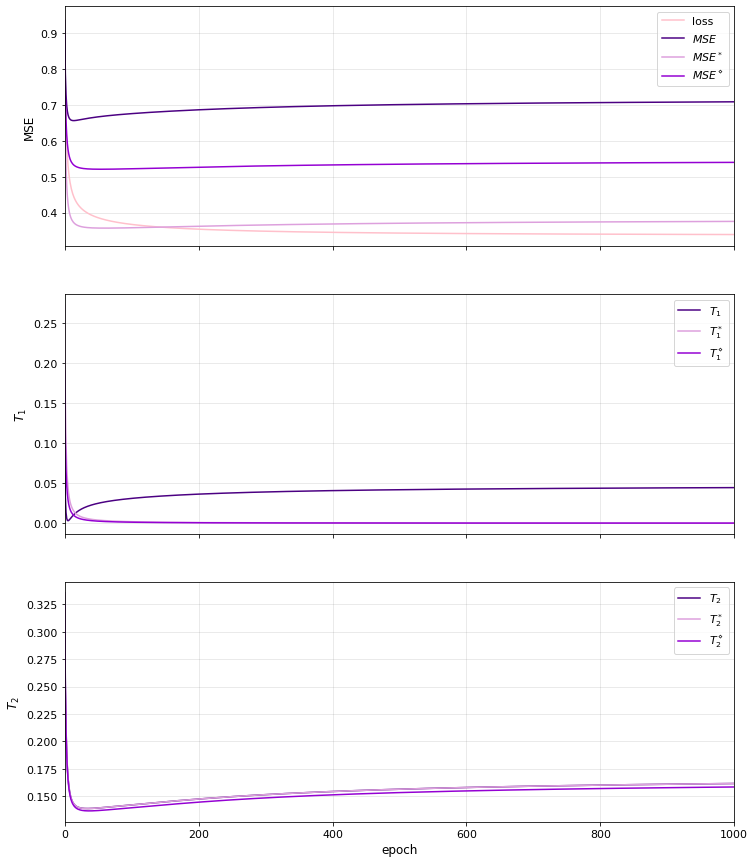

In [9]:
MSE = []
MSE_star =[]
MSE_diamond =[]

for i in range(3000):
    MSE.append(term_I_tab[i] + term_II_tab[i] + 1.0 - term_IV_tab[i])
    MSE_star.append(term_I_star_tab[i] + term_II_star_tab[i] + 1.0 - term_IV_star_tab[i])
    MSE_diamond.append(term_I_diamond_tab[i] + term_II_diamond_tab[i] + 1.0 - term_IV_diamond_tab[i])
    

fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

axs[0].plot(np.array(loss_tab)*10, color= 'pink', label = 'loss')

axs[0].plot(MSE, color= 'indigo', label = '$MSE$')
axs[1].plot(term_I_tab, color= 'indigo', label = '$T_1$')
axs[2].plot(term_II_tab, color= 'indigo', label = '$T_2$')
#axs[3].plot(term_IV_tab, color= 'indigo', label = 'original')

axs[0].plot(MSE_star, color= 'plum', label = '$MSE^*$')
axs[1].plot(term_I_star_tab, color= 'plum', label = '$T_1^*$')
axs[2].plot(term_II_star_tab, color= 'plum', label = '$T_2^*$')
#axs[3].plot(term_IV_star_tab, color= 'rebeccapurple', label = '$S^{31}$ improved')

axs[0].plot(MSE_diamond, color= 'darkviolet', label = '$MSE^\diamond$')
axs[1].plot(term_I_diamond_tab, color= 'darkviolet', label = '$T_1^\diamond$')
axs[2].plot(term_II_diamond_tab, color= 'darkviolet', label = '$T_2^\diamond$')
#axs[3].plot(term_IV_diamond_tab, color= 'plum', label = '$S^{11}$ improved')

for ax in axs:
    ax.grid(True, color='gray', alpha = 0.2)
    ax.legend(fontsize=11)
    ax.tick_params(axis='both', labelsize=11)


axs[0].set_ylabel('MSE', fontsize=12)
axs[1].set_ylabel('$T_1$',fontsize=12)
axs[2].set_ylabel('$T_2$',fontsize=12)
axs[-1].set_xlabel('epoch',fontsize=12)
axs[-1].set_xlim(0,1000)

In [12]:
df = pd.DataFrame()
df['loss'] = loss_tab
df['train_accuracy'] = train_accuracy_tab
df['test_accuracy'] = test_accuracy_tab

df['w1_mean'] = w1_mean_tab
df['w1_std'] = w1_std_tab
df['w2_mean'] = w2_mean_tab
df['w2_std'] = w2_std_tab

df['MSE'] = MSE
df['term_I'] = term_I_tab
df['term_II'] = term_II_tab
df['term_IV'] = term_IV_tab

df['MSE_star'] = MSE_star
df['term_I_star'] = term_I_star_tab
df['term_II_star'] = term_II_star_tab
df['term_IV_star'] = term_IV_star_tab

df['MSE_diamond']= MSE_diamond
df['term_I_diamond'] = term_I_diamond_tab
df['term_II_diamond'] = term_II_diamond_tab
df['term_IV_diamond'] = term_IV_diamond_tab

df.to_csv('terms_700.csv')